# Reference

1. http://docs.h2o.ai/h2o/latest-stable/h2o-docs/starting-h2o.html
2. https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/gbm-randomforest/GBM_RandomForest_Example.py
3. https://blog.h2o.ai/2017/06/xgboost-in-h2o-machine-learning-platform/
4. https://www.analyticsvidhya.com/blog/2016/05/h2o-data-table-build-models-large-data-sets/
5. https://aichamp.wordpress.com/2017/10/19/calculating-auc-and-gini-model-metrics-for-logistic-classification/
6. Parameter tuning: https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb
7. Interpreting h2o predictions: https://stackoverflow.com/questions/45523997/how-should-we-interpret-the-results-of-the-h2o-predict-function
8. Feature engineering: https://elitedatascience.com/feature-engineering-best-practices
9. Imputing missing values: https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
10. Beyond One-hot Encoding: http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/
11. Encoding Categorical Variables: https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931; https://www.kaggle.com/gargmanish/how-to-handle-imbalance-data-study-in-detail
12. Kaggle kernel on sampling data: https://www.kaggle.com/gargmanish/how-to-handle-imbalance-data-study-in-detail

# Load and Preprocess the Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import h2o
import os
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

/Users/araks/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('data_transactions/train.csv')
test = pd.read_csv('data_transactions/test.csv')

print('train Shape:', train.shape, 'test Shape:', test.shape)

train Shape: (348978, 51) test Shape: (523466, 50)


In [3]:
# drop id column
train_new = train.copy()
test_new = test.copy()

id_train = train_new.transaction_id
sub_ids = test_new.transaction_id

train_new.drop('transaction_id', axis = 1, inplace = True)
test_new.drop('transaction_id', axis = 1, inplace = True)

#train_new.dtypes

## Remove Features With Only One Distinct Value

In [4]:
cat_vars = [x for x in train_new.columns if 'cat_' in x]

# in training set
cat_to_drop_train = []
for x in cat_vars:
    if train_new[x].nunique() == 1:
        cat_to_drop_train.append(x)

# in test set
cat_to_drop_test = []
for x in cat_vars:
    if test_new[x].nunique() == 1:
        cat_to_drop_test.append(x)

# drop these features
cat_to_drop = list(set(cat_to_drop_train + cat_to_drop_test))
train_new = train_new.drop(cat_to_drop, axis = 1)
test_new = test_new.drop(cat_to_drop, axis = 1)

print(train_new.shape)
print(test_new.shape)

(348978, 42)
(523466, 41)


## Encode Categorical Features


In [5]:
from sklearn.preprocessing import LabelEncoder

cat_vars = [x for x in train_new.columns if 'cat_' in x]

for x in cat_vars:
    train_new[x] = train_new[x].fillna('NaN')
    test_new[x] = test_new[x].fillna('NaN')
    encoder = LabelEncoder()
    encoder.fit(list(set(list(train_new[x]) + list(test_new[x]))))
    train_new[x] = encoder.transform(train_new[x])
    test_new[x] = encoder.transform(test_new[x])
    
print(train_new.shape)
print(test_new.shape)

(348978, 42)
(523466, 41)


# Deal with Imbalanced Data

## Visualize *target* 

Fraud detection data are usualy very imbalanced (the number of normal classes is more than the number of fraud classes). The visual below shows the imbalanced classes.

normal(class 0): 0.892922, fraud(class 1): 0.107078


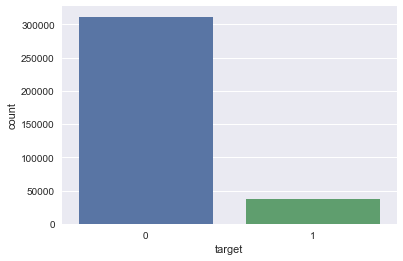

In [6]:
# Let's check the distribution of target variable
import seaborn as sns
%matplotlib inline

# Look at the classes of target variable in percentages
normal, fraud = train_new['target'].value_counts(normalize=True)
print('normal(class 0): %f, fraud(class 1): %f' % (normal, fraud))

ax = sns.countplot("target", data = train_new)

## Data Sampling

We are going to do
1. **Undersampling**, choosing all fraud transactions and only a portion of normal transactions.
2. **Oversampling**, choosing all of the data (both fraud and normal), plus replicated fraud transactions.

But befor doing the above two steps, let's define several helper functions.

### Define a function for undersampling  

**Note**: We will call the validation objects by the name "test". Our real test set is the *test_new*, which we will keep until the end, when we will make predictions and submit answers for evaluation. 

1. Split the training set into train and test(validation) sets.  
2. Undersample the train set only. This will assure that the distribution of test(validation) set is not changed.   

In [7]:
def undersample(train, response, p):    
    # train: training data frame that needs to be undersampled
    # response: name(string) of the response column
    # p: float, portion of normal classes that we want to have in the final data set. 
    #    More specifically, normal = fraud * p/(1-p)
    
    X = train.drop(response, axis = 1)
    y = train[response]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    X_train = X_train.join(y_train)     # adding the response column to splitted train set
    print("length of training data:", len(X_train))
    print("length of validation data:", len(X_test))

    train_normal = X_train[X_train[response] == 0]
    train_fraud = X_train[X_train[response] == 1]
    train_normal_under = train_normal.sample(n = int(round(len(train_fraud)*p/(1-p))), replace=False)
    train_under = train_normal_under.append(train_fraud)
    
    print('total number of records in undersampled training set:', len(train_under))
    print('portion of normal transactions in undersampled training set:', len(train_under[train_under[response]==0])/len(train_under))
    print('portion of fraud transactions in undersampled training set:', len(train_under[train_under[response]==1])/len(train_under))
    print('-----------------------------------------------------------------------------------------')
    
    X_train_under = train_under.drop(response, axis = 1)
    y_train_under = train_under[response]
    
    return (X_train_under, X_test, y_train_under, y_test)

### Define a function for oversampling  

1. Split the training into train and test(validation) sets.   
2. Add copied fraud columns in train set only. This will assure that in our test(validation) set there are no fraud observations that we have already seen while training our model(s). We are not changing the distribution of test(validation) set.  

In [8]:
def oversample(train, response, p):
    # train: training data frame that needs to be oversampled
    # response: name(string) of the response column
    # p: float, the resulting fraud classes are less than p*total_rows
    
    X = train.drop(response, axis = 1)
    y = train[response]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    X_train = X_train.join(y_train)     # adding the response column to splitted train set
    print("length of training data:", len(X_train))
    print("length of validation data:", len(X_test))
    
    normal_data = X_train[X_train[response] == 0]
    fraud_data = X_train[X_train[response] == 1]
    total_fraud = len(X_train[X_train[response] == 1])
    
    while total_fraud < (len(normal_data))*p:
        normal_data = normal_data.append(fraud_data)
        total_fraud = len(normal_data[normal_data[response] == 1])
        
    train_over = normal_data.copy()
    print('total number of records in oversampled training set:', len(train_over))
    print('portion of normal transactions in oversampled training set:', len(train_over[train_over[response]==0])/len(train_over))
    print('portion of fraud transactions in oversampled training set:', len(train_over[train_over[response]==1])/len(train_over))
    print('----------------------------------------------------------------------------------------------')
    
    X_train_over = train_over.drop(response, axis = 1)
    y_train_over = train_over[response]
    
    return (X_train_over, X_test, y_train_over, y_test) 

# H2O

In [9]:
### start h2o
h2o.init()     #h2o.cluster().shutdown() # in the end

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 19 hours 31 mins
H2O cluster version:,3.16.0.2
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_araks_rzi2qe
H2O cluster total nodes:,1
H2O cluster free memory:,1.294 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [10]:
### Convert Pandas Data Frame to H2o Frame
#train_h2o = h2o.H2OFrame(train_new)   # do not convert train_new, as we will do it later after undersampling it
test_h2o = h2o.H2OFrame(test_new)

Parse progress: |███████████████████████████████████████████████████████████████| 100%


In [11]:
### Predictors and Response
predictors_X = train_new.columns.values.tolist()
response_y = 'target'

### gbm object
gbm = H2OGradientBoostingEstimator(
    ntrees=50,
    learn_rate=0.2,
    max_depth=10,
    #stopping_tolerance=0.01,
    #stopping_rounds=2,
    score_each_iteration=True,
    model_id="gbm_covType_v2",
    seed=2000000
    )

## Undersample Training

In [14]:
### Do undersampling and fitting 4 times resulting in normal class portion of 0.25, 0.3, 0.4, and 0.5
for i in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print("Undersampled data for {} proportion".format(i))
    X_train_under, X_test_1, y_train_under, y_test_1 = undersample(train_new, 'target', i)
    
    ### For h2o we need the training and validation sets with the response column
    ### So add the response column back
    X_train_under = X_train_under.join(y_train_under)     
    X_test_1 = X_test_1.join(y_test_1)
    
    ### Convert train and valid sets from pandas to h2o Frame
    train_under = h2o.H2OFrame(X_train_under)
    valid_under = h2o.H2OFrame(X_test_1)
    
    ### Convert the response column to factor
    train_under['target'] = train_under['target'].asfactor()
    valid_under['target'] = valid_under['target'].asfactor()
    
    ### Train
    print("-------------------------- Start the Training ------------------------------")
    gbm.train(predictors_X, response_y, training_frame = train_under, validation_frame = valid_under)

    ### Print the scores for training and validation sets
    print('training score:', gbm.auc(train = True))
    print('validation score:', gbm.auc(valid = True))   
    print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')

Undersampled data for 0.2 proportion
length of training data: 244284
length of validation data: 104694
total number of records in undersampled training set: 32656
portion of normal transactions in undersampled training set: 0.19999387555120038
portion of fraud transactions in undersampled training set: 0.8000061244487996
-----------------------------------------------------------------------------------------
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
-------------------------- Start the Training ------------------------------
gbm Model Build progress: |███████████████████████████████████████████████| 100%
training score: 0.8741524287186836
validation score: 0.7175923682603422
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Undersampled data for 0.3 proportion
length of training data: 244284
length of validation data: 104694
tot

## Oversample Training

This will take more than 15 minutes.

In [13]:
### Do oversampling and fitting 4 times resulting in fraud class portion of 0.25, 0.3, 0.4, and 0.5
for i in [0.25, 0.3, 0.4, 0.5]:
    print("Oversampled data for {} proportion".format(i))
    X_train_over, X_test_2, y_train_over, y_test_2 = oversample(train_new, 'target', i)
    
    ### For h2o we need the training and validation sets with the response column
    ### So add the response column back
    X_train_over = X_train_over.join(y_train_over)     
    X_test_2 = X_test_2.join(y_test_2)
    
    ### Convert train and valid sets from pandas to h2o Frame
    train_over = h2o.H2OFrame(X_train_over)
    valid_over = h2o.H2OFrame(X_test_2)
    
    ### Convert the response column to factor
    train_over['target'] = train_over['target'].asfactor()
    valid_over['target'] = valid_over['target'].asfactor()
    
    ### Train
    print("-------------------------- Start the Training ------------------------------")
    gbm.train(predictors_X, response_y, training_frame = train_over, validation_frame = valid_over)

    ### Print the scores for training and validation sets
    print('training score:', gbm.auc(train = True))
    print('validation score:', gbm.auc(valid = True))   
    print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')

Oversampled data for 0.25 proportion
length of training data: 244284
length of validation data: 104694
total number of records in oversampled training set: 296770
portion of normal transactions in oversampled training set: 0.7347137513899653
portion of fraud transactions in oversampled training set: 0.2652862486100347
----------------------------------------------------------------------------------------------
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
-------------------------- Start the Training ------------------------------
gbm Model Build progress: |███████████████████████████████████████████████| 100%
training score: 0.8120509952612746
validation score: 0.7222622464152813
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Oversampled data for 0.3 proportion
length of training data: 244284
length of validation data: 104694
to

## Predict on Test Data (Undersample)

**Note**: Run the 4 cells bellow for undersampled data submission

Choose the highest validation score and see what portion of normal class it corresponds to. Do undersampling again but this time on all of the data, do not split (do not use the function undersample).
Change the portion (line 3) in the code below to the desired portion.

In [33]:
train_normal = train_new[train_new['target'] == 0]
train_fraud = train_new[train_new['target'] == 1]
train_normal_under = train_normal.sample(n = int(round(len(train_fraud)*0.2/(1-0.2))), replace=False)
train_under = train_normal_under.append(train_fraud)
    
print('total number of records in undersampled training set:', len(train_under))
print('portion of normal transactions in undersampled training set:', len(train_under[train_under['target']==0])/len(train_under))
print('portion of fraud transactions in undersampled training set:', len(train_under[train_under['target']==1])/len(train_under))
print('-----------------------------------------------------------------------------------------')
    
train_h2o_under = h2o.H2OFrame(train_under)
train_h2o_under['target'] = train_h2o_under['target'].asfactor()  

total number of records in undersampled training set: 46710
portion of normal transactions in undersampled training set: 0.2
portion of fraud transactions in undersampled training set: 0.8
-----------------------------------------------------------------------------------------
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [34]:
### Train
gbm.train(predictors_X, response_y, training_frame = train_h2o_under)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [35]:
### Predict
final_gbm_predictions_under = gbm.predict(test_h2o)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [36]:
# convert h2o predictions to pandas data frame
preds_pandas_under = h2o.as_list(final_gbm_predictions_under)
# we need column 'p1' as it is the probability of target==1
preds_under = preds_pandas_under['p1']

## Predict on Test Data (Oversample)

**Note**: Run the 4 cells bellow for oversampled data submission

Choose the highest validation score and see what portion of fraud class it corresponds to. Do oversampling again but this time on all of the data, do not split (do not use the function oversample).
Change the portion in the code below to the desired portion.

In [23]:
train_normal = train_new[train_new['target'] == 0]
train_fraud = train_new[train_new['target'] == 1]
train_fraud_count = len(train_fraud)

while train_fraud_count < (len(train_normal))*0.25:
        train_normal = train_normal.append(train_fraud)
        train_fraud_count = len(train_normal[train_normal['target'] == 1])
        
train_over = train_normal.copy()
print('total number of records in oversampled training set:', len(train_over))
print('portion of normal transactions in oversampled training set:', len(train_over[train_over['target']==0])/len(train_over))
print('portion of fraud transactions in oversampled training set:', len(train_over[train_over['target']==1])/len(train_over))
print('----------------------------------------------------------------------------------------------')
 
train_h2o_over = h2o.H2OFrame(train_over)
train_h2o_over['target'] = train_h2o_over['target'].asfactor()

total number of records in oversampled training set: 423714
portion of normal transactions in oversampled training set: 0.735425310468854
portion of fraud transactions in oversampled training set: 0.264574689531146
----------------------------------------------------------------------------------------------
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [25]:
### Train
gbm.train(predictors_X, response_y, training_frame = train_h2o_over)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [26]:
### Predict
final_gbm_predictions_over = gbm.predict(test_h2o)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [27]:
# convert h2o predictions to pandas data frame
preds_pandas_over = h2o.as_list(final_gbm_predictions_over)
# we need column 'p1' as it is the probability of target==1
preds_over = preds_pandas_over['p1']

## Submission

**Note**: Uncomment the first line if submiting the undersampled results and uncomment the second line for the oversampled results.

In [37]:
preds = preds_under.copy()
#preds = preds_over.copy()

In [38]:
print(sub_ids.shape)
print(preds.shape)

(523466,)
(523466,)


In [39]:
from IPython.display import FileLink

sub = pd.DataFrame({'transaction_id': sub_ids, 'target': preds})
sub = sub[['transaction_id','target']]    

filename='sub_transactions.csv'
sub.to_csv(filename, index=False)
FileLink(filename)      # lb 0.72597

/Users/araks/Documents/AS_projects/Competitions/hackerearth/BrainWaves2017_18/sub_transactions.csv